# Introduction

# Business Understanding

## Imagine you are working in a company who analyze hotels/guest houses/vacation rentals bookings, tourist visiting and pricing patterns.

## You would like to use Airbnb_Seattle data to answer your questions

## Business context - You would like to understand and assess people inflow, price varying factors and predictions

## Questions -

### 1) What are the busiest times to visit Seattle?
### 2)Which areas/neighborhoods are costly in Seattle?
### 3)What are the factors of an Airbnb that effects pricing?

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)


#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

# Data Understanding - load the excel files

In [2]:
calen=pd.read_csv("calendar.csv")
listings=pd.read_csv("listings.csv")
review=pd.read_csv("reviews.csv")

In [3]:
print(calen.shape)
calen.head(3)

(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN


In [4]:
print(listings.shape)
listings.head(3)

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [5]:
print(review.shape)
review.head(3)

(84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."


# Data Preparation - Data Cleaning

In [6]:
#Helper functions for dataset cleaning

def get_month_from_date(row):
    ''' Get month from date represented as a string '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Get year from date represented as a string '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' Return 1 when the is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

#Main dataset cleaning function
def clean_dataset(listings_df, calendar_df):
    '''
    INPUT
    listings_df - pandas dataframe containing listings data 
    calendar_df - pandas dataframe containing calendar data
    
    OUTPUT
    df - cleaned dataset, which contains merged tables:
    1. irrelevant columns are dropped;
    2. string containing dates are converted into numbers;
    3. columns, containing lists, are split into several columns (for example, amenities)
    4. missing values are imputed with mean or mode.
    '''
    #merge datasets
    listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listings_df, on = 'listing_id')
    
    #drop the irrelevant columns
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month']
    df = df.drop(columns = columns_to_drop)
    
    #convert date from the calendar into month and drop the date colum
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df = df.drop(columns = ['date'])
    
    #remove rows where price_x == nan, because price will be used as response column
    df = df.dropna(subset=['price_x'])
    
    #convert price to number and drop the price_x column
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    
    #convert host_since date into number and fill in missing values, drop the original column
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])
    
    #convert host_response_rate into number and fill in missing values, drop the original column
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)
    
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    #fill missing values with mean value for host_listings_count
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)
    
    #split host_verifications into dummy columns and drop the original column
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    #fill in missing values for bathrooms, bedrooms and beds with mode
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    #split amenities into dummy columns and drop the original column
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    #turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])
    
    #fill missing values for review scores columns
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

In [7]:
df = clean_dataset(listings, calen)

In [8]:
df.head(3)

,listing_id,host_response_time,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,...,amenities_Heating,amenities_Kitchen,amenities_Smoke Detector,amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV,extra_people_fee
0,241032,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,241032,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
9,241032,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


# It's not always about ML. Some of our questions can be easily answered with an exploratory data analysis

## Q1) What are the busiest times to visit Seattle?

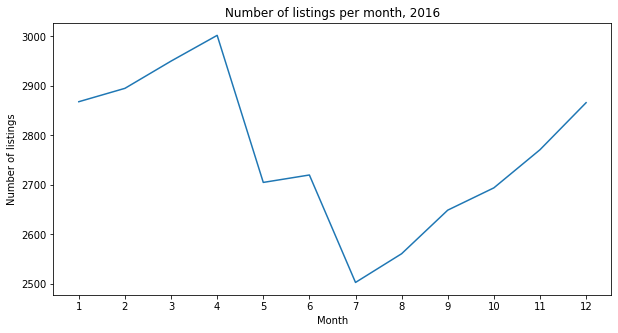

In [12]:
#find number of total number of listings for each month in 2016
number_of_listings_by_month = pd.Series([12])
for i in range(1, 13):
    number_of_listings_by_month[i] = len(df[(df['month'] == i) & (df['year'] == 2016)]['listing_id'].unique())
    
number_of_listings_by_month = number_of_listings_by_month.drop(0)

#plot
plt.figure(figsize=(10,5))
plt.plot(number_of_listings_by_month)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month, 2016')

plt.savefig('number of available listings.png')

plt.show()

## How price vary per month?

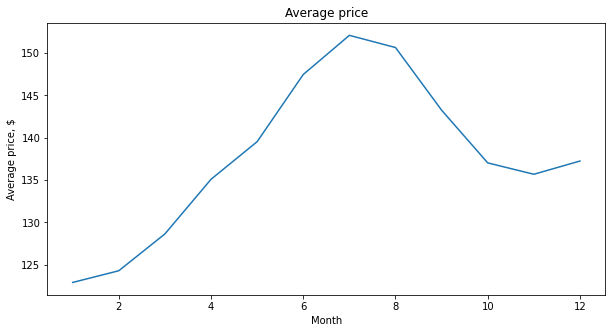

In [13]:
#find average price by month
average_price_by_month = df.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_by_month)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')

plt.savefig('average price for month')

plt.show()

## 2)Which areas/neighborhoods are costly in Seattle?

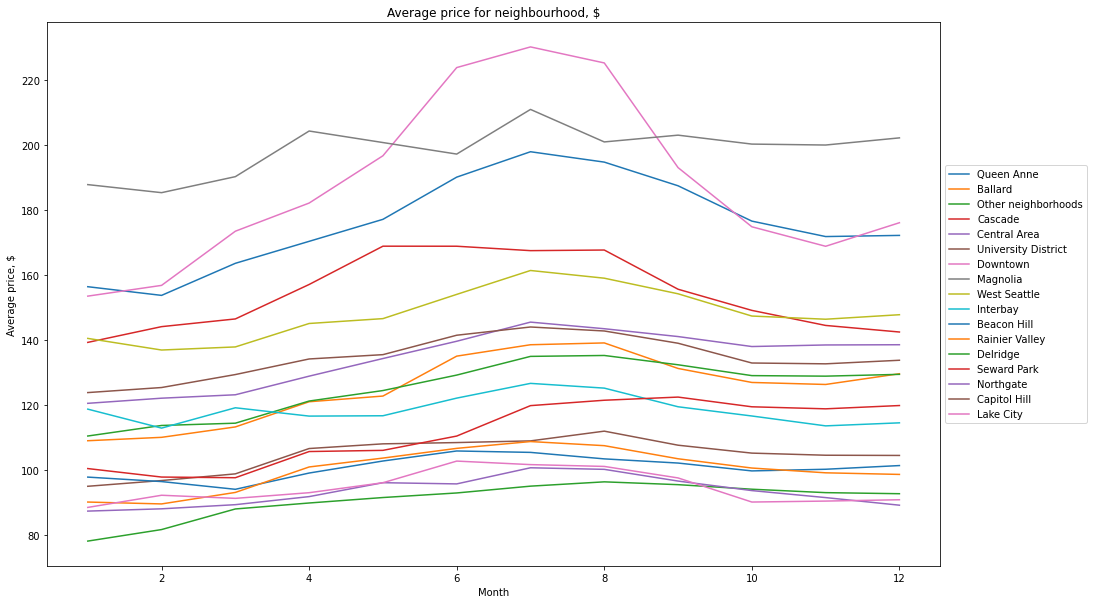

In [14]:
#get list of neighbourhoods
neighbourhoods = df['neighbourhood_group_cleansed'].unique()

#get prices by month and neighbourhood
price_by_month_neighbourhood = df.groupby(['month','neighbourhood_group_cleansed']).mean().reset_index()

#plot prices for each neighbourhood
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

for neighbourhood in neighbourhoods:
    ax.plot(price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['month'],
             price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['price'],
             label = neighbourhood)
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price for neighbourhood, $')

plt.savefig('average price for neighbourhood')

plt.show()

## 3)What are the factors of an Airbnb that effects pricing?

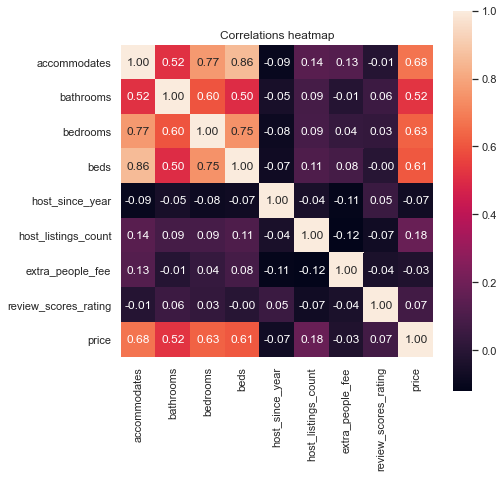

In [15]:
#Numerical columns to find out correlation
cols = ['accommodates','bathrooms','bedrooms','beds','host_since_year',
        'host_listings_count', 'extra_people_fee',
        'review_scores_rating', 'price']

#Find out correlation between columns and plot
corrs = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')

# Data Modelling 

## Now lets do feature engineering and try to predict the price of a listing

In [23]:
#turn categorical columns into dummies
cat_columns = list(df.columns[df.dtypes=="object"])
    
for col in  cat_columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=True)], axis=1)
#drop listing_id and year columns
df = df.drop(columns = ['listing_id', 'year'])

In [24]:
#prepare train and test datasets for modelling
TEST_SIZE = 0.3
RAND_STATE = 42

X = df.drop(columns = 'price')
y = df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

## Training and evaluation

In [25]:
#train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=RAND_STATE, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 186.973, test: 211.258
Random Forest R^2 train: 0.983, test: 0.981
